
Evaluating on 25x25 grid (v_max=0.07)
Loading: ./Data/kijs_25x25elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  8.802054671146341e-07
Units are in: mm,N,ms,MPa,gr

Evaluating TQC alpha=0.5 on grid 25x25...

Evaluating TQC alpha=0.5 on grid 25x25...
[TQC alpha=0.5 run0] WARNING: time stuck at 1.2307572199781014
[TQC alpha=0.5 run0] Done: wall_time=0.503s, steps=10, final_t=1.231, s_end=1.132171e-01

Evaluating TQC alpha=128 on grid 25x25...
[TQC alpha=0.5 run0] WARNING: time stuck at 1.2307572199781014
[TQC alpha=0.5 run0] Done: wall_time=0.503s, steps=10, final_t=1.231, s_end=1.132171e-01

Evaluating TQC alpha=128 on grid 25x25...
[TQC alpha=128 run0] WARNING: time stuck at 1.370382233394416
[TQC alpha=128 run0] Done: wall_time=0.465s, steps=11, final_t=1.370, s_end=1.494481e-01

Evaluating TQC alpha=16 on 

/tmp/ipykernel_23224/1901360395.py:84: RuntimeWarning: overflow encountered in exp
  mu_vals = MU_RES * (1.0 - DMU / MU_RES * np.exp(-slip_hist / dc_scaled))


  PI baseline run 0: 11.658s, success=True
Saved results to eval_results_25x25.json


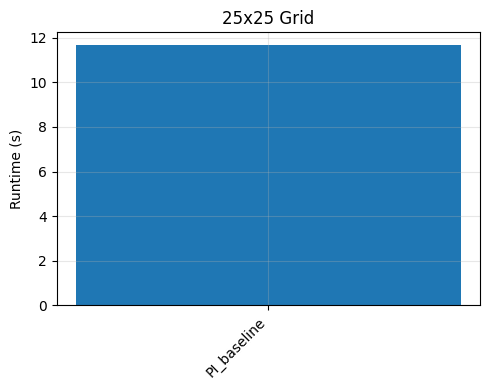


EVALUATION COMPLETE


In [1]:
import numpy as np
import time
import json
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.sparse as sp

from gymnasium import spaces
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from sb3_contrib import TQC
# from stable_baselines3 import TD3

from Solve_IVP_NS.projections import CoulombProjection
from Solve_IVP_NS.nonlinear_solvers import ImplicitEquationSolver
from Solve_IVP_NS.integrations import CompositeMethod
from Solve_IVP_NS.rl.env import AdaptiveStepperEnv
import Solve_IVP_NS
from plants.faults import strikeslip

###############################################################################
# Configuration
###############################################################################
ALGO_REGISTRY = {
    "TQC": TQC,
    # "TD3": TD3,
}

RUN_ROOT = Path("rl_runs").resolve()
N_EVAL_RUNS = 1  # Number of evaluation runs for runtime averaging

GRID_SPECS = [
    # {"Nz": 1, "Nx": 1, "label": "1x1", "v_max": 0.07},  # Training grid
    {"Nz": 25, "Nx": 25, "label": "25x25", "v_max": 0.07},  # Same v_max as 1x1
    # {"Nz": 50, "Nx": 50, "label": "50x50", "v_max": 0.07},  # Same v_max as 1x1
    # {"Nz": 75, "Nx": 75, "label": "75x75", "v_max": 0.07},  # Same v_max as 1x1
    # {"Nz": 100, "Nx": 100, "label": "100x100", "v_max": 0.07},  # Same v_max as 1x1

    # {"Nz": 5, "Nx": 5, "label": "5x5", "v_max": 0.18},  # Different v_max
]

DMU = -0.1
DC = 100.0  # Scaled by each fault.Dscale
MU_RES = 0.5

# Shared nonlinear-solver options (match training notebook)
SOLVER_OPTS_COMMON = dict(tol=1e-6, max_iter=100)
SOLVER_OPTS_SSN = dict(SOLVER_OPTS_COMMON)
SOLVER_OPTS_SSN.update({
    "vi_strict_block_lipschitz": False,
    "vi_max_block_adjust_iters": 10,
    "globalization": "line_search",
})

###############################################################################
# Build fault and solver for a given grid
###############################################################################
def build_fault_and_solver(Nz, Nx):
    """Construct the plant, projection, and solver objects for a grid size."""
    fault_local = strikeslip.qs_strikeslip_fault(
        zdepth=3, xlength=3, Nz=Nz, Nx=Nx,
        G=30000.0, rho=2.5e-3, zeta=0.8 / 3,
        Ks_path="./Data/", gamma_s=25.0, gamma_w=10.0,
        sigma_ref=100.0, depth_ini=0.0, vinf=3.171e-10,
        Dmu_estimate=0.5,
    )

    MA_l, KS_l, ES_l, SIGMA_N_l, VINF_raw_l = fault_local.get_plant()
    n_dofs = fault_local.N
    VINF_l = VINF_raw_l * np.ones(n_dofs) * 0.0  # Force rest velocity to zero
    
    I_N = sp.eye(n_dofs, format="csr")
    A_l = sp.block_diag([sp.csr_matrix(MA_l), I_N, I_N], format="csr")

    component_slices_l = [
        slice(0, n_dofs),
        slice(n_dofs, 2 * n_dofs),
        slice(2 * n_dofs, 3 * n_dofs),
    ]

    dc_scaled = DC / fault_local.Dscale

    def con_force_l(state, fk=None):
        slip_hist = state[2 * n_dofs : 3 * n_dofs]
        mu_vals = MU_RES * (1.0 - DMU / MU_RES * np.exp(-slip_hist / dc_scaled))
        out = np.zeros_like(state)
        out[:n_dofs] = mu_vals * SIGMA_N_l
        return out

    y0_l = np.zeros(3 * n_dofs)
    friction_force0 = con_force_l(y0_l)
    uc = -np.linalg.solve(KS_l, friction_force0[:n_dofs])
    y0_l[n_dofs : 2 * n_dofs] = uc * (1.0 + 1e-5)

    Uintc_l = 0.5 * float(uc @ (KS_l @ uc))

    projection_l = CoulombProjection(
        con_force_func=con_force_l,
        rhok=np.ones(n_dofs, dtype=float),
        component_slices=component_slices_l,
        constraint_indices=list(range(n_dofs)),
        use_numba=True,
    )

    solver_mp_l = ImplicitEquationSolver(
        method="VI",
        proj=projection_l,
        component_slices=component_slices_l,
        tol=SOLVER_OPTS_SSN.get("tol", 1e-6),
        max_iter=SOLVER_OPTS_SSN.get("max_iter", 100),
        vi_strict_block_lipschitz=SOLVER_OPTS_SSN.get("vi_strict_block_lipschitz", False),
        vi_max_block_adjust_iters=SOLVER_OPTS_SSN.get("vi_max_block_adjust_iters", 10),
        globalization=SOLVER_OPTS_SSN.get("globalization", "none"),
    )

    method_mp_l = CompositeMethod(solver=solver_mp_l, A=A_l)

    def rhs_l(t, y):
        v = y[:n_dofs]
        u = y[n_dofs : 2 * n_dofs]
        vdot = -(KS_l @ u) - (ES_l @ (v - VINF_l))
        udot = v - VINF_l
        sdot = np.abs(v)
        return np.concatenate((vdot, udot, sdot))

    return dict(
        fault=fault_local,
        KS=KS_l,
        ES=ES_l,
        SIGMA_N=SIGMA_N_l,
        VINF=VINF_l,
        N_DOFS=n_dofs,
        A=A_l,
        component_slices=component_slices_l,
        con_force=con_force_l,
        y0=y0_l,
        Uintc=Uintc_l,
        method_mp=method_mp_l,
        rhs=rhs_l,
        DC_scaled=dc_scaled,
    )

###############################################################################
# Observation/reward helpers (SIGNED dt_norm)
###############################################################################
def build_reward_fn(alpha_value: float):
    alpha_value = float(alpha_value)

    def reward_fn(solver_perf, dt_attempt, xk, env):
        (
            runtime_inc,
            dts,
            error_LO,
            error_lil1,
            error_HI,
            E,
            success_LO,
            success_lil1,
            success_HI,
            kiter_LO,
            iter_lil1,
            kiter_HI,
        ) = solver_perf

        dt_range = env.dt_max - env.dt_min
        if dts == 0.0:
            dt_norm_attempt = (dt_attempt - env.dt_min) / dt_range
            return -dt_norm_attempt

        dt_norm = (dts - env.dt_min) / dt_range
        S1 = float(np.clip(dt_norm, 0.0, 1.0))

        if not hasattr(env, "runtime_history"):
            env.runtime_history = []
        env.runtime_history.append(float(runtime_inc))

        env.max_runtime_seen = max(getattr(env, "max_runtime_seen", float(runtime_inc)), float(runtime_inc))
        env.min_runtime_seen = min(getattr(env, "min_runtime_seen", float(runtime_inc)), float(runtime_inc))

        rt_min = float(env.min_runtime_seen)
        rt_max = max(rt_min, float(env.max_runtime_seen))
        denom = max(1e-8, rt_max - rt_min)
        S2 = 1 - (float(runtime_inc) - rt_min) / denom

        A_val = float(np.exp(-alpha_value * E))
        return S1 * S2 * A_val

    return reward_fn

def make_obs_reward(alpha_value, grid, v_max_override):
    reward_fn = build_reward_fn(alpha_value)

    def obs_fn(dt_attempt, converged, xk, solver_perf, fk=None, env=None):
        assert env is not None, "env must be provided"
        n = grid["N_DOFS"]
        v = xk[:n]
        u = xk[n : 2 * n]

        avg_v = float(np.mean(v))
        ks_u = grid["KS"] @ u
        E_int = 0.5 * float(np.dot(u, ks_u))
        E_norm = float(E_int / grid["Uintc"]) if grid["Uintc"] > 0 else float(E_int)

        if solver_perf is not None:
            dts = solver_perf[1]
            conv_flag_bipolar = 1.0 if dts > 0.0 else -1.0
        else:
            conv_flag_bipolar = -1.0

        if dt_attempt is None or solver_perf is None:
            dt_norm_default = 0.5
            conv_flag = 0.0 if converged is None else float(converged)
            return np.array([
                E_norm,
                avg_v / (v_max_override / grid["fault"].Vscale),
                (env.iter_error / 4.0) if hasattr(env, "iter_error") else 0.0,
                conv_flag,
                0.0,
                conv_flag_bipolar * dt_norm_default,
            ], dtype=np.float64)

        (
            runtime_inc,
            dts,
            error_LO,
            error_lil1,
            error_HI,
            E_global,
            success_LO,
            success_lil1,
            success_HI,
            kiter_LO,
            iter_lil1,
            kiter_HI,
        ) = solver_perf

        dt_range = env.dt_max - env.dt_min
        if dt_range <= 0.0:
            dt_norm = 0.0
        else:
            dt_norm = float(np.clip((dt_attempt - env.dt_min) / dt_range, 0.0, 1.0))

        conv_flag = float(converged) if converged is not None else 0.0
        acc = 1.0 / (1.0 + E_global) if conv_flag else 0.0

        return np.array([
            E_norm,
            avg_v / (v_max_override / grid["fault"].Vscale),
            (env.iter_error / 4.0) if hasattr(env, "iter_error") else 0.0,
            conv_flag,
            acc,
            conv_flag_bipolar * dt_norm,
        ], dtype=np.float64)

    return reward_fn, obs_fn

###############################################################################
# Rollout helper
###############################################################################
def rollout_policy_on_vecenv(model, vec_env, run_name="(unnamed)"):
    vec_env.training = False
    vec_env.norm_obs = False
    vec_env.norm_reward = False

    obs = vec_env.reset()
    times, mean_vel, mean_slip = [], [], []
    last_t = None
    repeat_count = 0
    broke_stuck = False
    last_converged = None
    last_xk = None

    start = time.time()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, rewards, dones, infos = vec_env.step(action)

        done = bool(dones[0])
        info = infos[0]

        t_now = info.get("t_k1", np.nan)
        xk = info.get("xk")
        if xk is not None:
            last_xk = xk

        if "converged" in info:
            last_converged = info.get("converged")

        current_t = None if t_now is None or np.isnan(t_now) else float(t_now)
        if current_t is not None:
            if last_t is not None and current_t == last_t:
                repeat_count += 1
                if repeat_count >= 10:
                    print(f"[{run_name}] WARNING: time stuck at {current_t}")
                    broke_stuck = True
                    break
            else:
                repeat_count = 0
            last_t = current_t

        if xk is not None and current_t is not None:
            n = xk.shape[0] // 3
            v_block = xk[:n]
            u_block = xk[n : 2 * n]
            times.append(current_t)
            mean_vel.append(float(np.mean(v_block)))
            mean_slip.append(float(np.mean(u_block)))

    wall_time = time.time() - start

    base_env = vec_env.venv.envs[0]
    if last_converged is not None:
        success = bool(last_converged)
    elif len(times) > 0 and hasattr(base_env, "tnmax"):
        success = (times[-1] >= 0.999 * float(base_env.tnmax)) and not broke_stuck
    else:
        success = not broke_stuck

    if last_xk is not None:
        n = last_xk.shape[0] // 3
        s_block = last_xk[2 * n : 3 * n]
        s_end_mean = float(np.mean(s_block))
    else:
        s_end_mean = np.nan

    print(
        f"[{run_name}] Done: wall_time={wall_time:.3f}s, steps={len(times)}, "
        f"final_t={(times[-1] if times else float('nan')):.3f}, s_end={s_end_mean:.6e}",
    )

    return (
        np.asarray(times, dtype=float),
        np.asarray(mean_vel, dtype=float),
        np.asarray(mean_slip, dtype=float),
        float(wall_time),
        bool(success),
        s_end_mean,
    )

###############################################################################
# Evaluation helpers
###############################################################################
def evaluate_policies_for_grid(grid, spec, alpha_dirs):
    v_max_override = spec["v_max"]
    grid_label = spec["label"]

    local_dt_min = 1e-7
    local_t_end = 30 * grid["fault"].second / grid["fault"].Tscale
    local_dt_max = (30.0 / 5.0) * grid["fault"].second / grid["fault"].Tscale
    local_t_span = (0.0, local_t_end)

    series = {}

    for alpha_dir in alpha_dirs:
        algo_dirs = sorted(p for p in alpha_dir.iterdir() if p.is_dir())

        for algo_dir in algo_dirs:
            algo_name = algo_dir.name
            ModelClass = ALGO_REGISTRY.get(algo_name)
            if ModelClass is None:
                continue

            meta_path = algo_dir / "metadata.json"
            model_path = algo_dir / "model.zip"
            if not model_path.exists():
                model_path = algo_dir / "model"
            vecnorm_path = algo_dir / "vec_norm.pkl"

            if not meta_path.exists() or not model_path.exists():
                continue

            with open(meta_path, "r", encoding="utf-8") as fh:
                meta = json.load(fh)

            alpha_value = float(meta.get("alpha", np.nan))
            if not np.isfinite(alpha_value):
                continue

            reward_fn, obs_fn = make_obs_reward(alpha_value, grid, v_max_override)

            def make_env():
                obs_space = spaces.Box(
                    low=-np.inf,
                    high=np.inf,
                    shape=(6,),
                    dtype=np.float64,
                )
                return AdaptiveStepperEnv(
                    system=grid["rhs"],
                    dt0=local_dt_min,
                    t0=local_t_span[0],
                    x0=grid["y0"],
                    tnmax=local_t_span[1],
                    dt_min=local_dt_min,
                    dt_max=local_dt_max,
                    nparams=(1e-6, 100.0),
                    integrator=grid["method_mp"],
                    component_slices=grid["component_slices"],
                    reward_fn=reward_fn,
                    obs_fn=obs_fn,
                    obs_space=obs_space,
                    verbose=False,
                    alpha=alpha_value,
                )

            model = ModelClass.load(str(model_path), device="cpu")

            runtimes = []
            success_runs = []
            slip_end_list = []
            t_store = None
            v_store = None
            u_store = None

            key = f"{algo_name} alpha={alpha_value:g}"
            print(f"\nEvaluating {key} on grid {grid_label}...")

            for run_idx in range(N_EVAL_RUNS):
                base_vec_env = DummyVecEnv([make_env])

                if vecnorm_path.exists():
                    vec_env = VecNormalize.load(str(vecnorm_path), base_vec_env)
                    vec_env.training = False
                    vec_env.norm_obs = False
                    vec_env.norm_reward = False
                else:
                    vec_env = base_vec_env

                model.set_env(vec_env)

                t_arr, v_mean, u_mean, wall, success, s_end_mean = rollout_policy_on_vecenv(
                    model, vec_env, run_name=f"{key} run{run_idx}",
                )

                runtimes.append(wall)
                success_runs.append(success)
                slip_end_list.append(s_end_mean)

                if run_idx == 0:
                    t_store = t_arr
                    v_store = v_mean
                    u_store = u_mean

                vec_env.close()

                if run_idx == 0 and not success:
                    break

            if any(success_runs):
                fault_scales = grid["fault"]
                time_scale = fault_scales.Tscale / fault_scales.second
                vel_scale = fault_scales.Vscale
                slip_scale = fault_scales.Dscale

                times_phys = np.asarray(t_store, dtype=float) * time_scale if t_store is not None else np.array([])
                mean_v_phys = np.asarray(v_store, dtype=float) * vel_scale if v_store is not None else np.array([])
                mean_u_phys = np.asarray(u_store, dtype=float) * slip_scale if u_store is not None else np.array([])
                finite_slip = [s for s in slip_end_list if np.isfinite(s)]
                s_end_mean_phys = float(np.mean(finite_slip) * slip_scale) if finite_slip else float("nan")

                series[key] = dict(
                    times=times_phys,
                    mean_v=mean_v_phys,
                    mean_u=mean_u_phys,
                    runtime_s=float(np.mean(runtimes)),
                    runtime_std=float(np.std(runtimes)) if len(runtimes) > 1 else 0.0,
                    converged=True,
                    success_rate=sum(success_runs) / len(success_runs),
                    s_end_mean=s_end_mean_phys,
                )
                print(
                    f"  Success rate: {series[key]['success_rate']:.1%}, runtime={series[key]['runtime_s']:.3f}s ± {series[key]['runtime_std']:.3f}s"
                )

    return series

###############################################################################
# Classical PI baseline
###############################################################################
def adaptive_baseline_for_grid(grid, adaptive_opts):
    projection_opts_nb = dict(
        con_force_func=grid["con_force"],
        rhok=np.ones(grid["N_DOFS"], dtype=float),
        component_slices=grid["component_slices"],
        constraint_indices=list(range(grid["N_DOFS"])),
        use_numba=True,
    )
    

    local_adapt = dict(adaptive_opts)
    # local_adapt["use_PI"] = True

    local_t_span = (0.0, 30 * grid["fault"].second / grid["fault"].Tscale)

    runtimes_b = []
    success_runs = []
    slip_end_list = []
    t_store = None
    y_store = None

    for run_idx in range(N_EVAL_RUNS):
        start_b = time.time()
        try:
            (
                t_vals_b,
                y_vals_b,
                h_vals_b,
                fk_vals_b,
                solver_info_b,
            ) = Solve_IVP_NS.solve_ivp_ns(
                fun=grid["rhs"],
                t_span=local_t_span,
                y0=grid["y0"],
                method="composite",
                projection="coulomb",
                solver="VI",
                projection_opts=projection_opts_nb,
                solver_opts=SOLVER_OPTS_SSN,
                adaptive=True,
                adaptive_opts=local_adapt,
                h0=local_adapt.get("h0", 5e-3),
                component_slices=grid["component_slices"],
                verbose=False,
                A=grid["A"],
            )
            wall_b = time.time() - start_b

            success = bool(len(t_vals_b) > 0 and t_vals_b[-1] >= 0.999 * local_t_span[1])
            success_runs.append(success)
            runtimes_b.append(wall_b)

            n = grid["N_DOFS"]
            s_final_block = y_vals_b[-1, 2 * n : 3 * n]
            s_end_mean = float(np.mean(s_final_block))
            slip_end_list.append(s_end_mean)

            if run_idx == 0:
                t_store = t_vals_b
                y_store = y_vals_b

            print(f"  PI baseline run {run_idx}: {wall_b:.3f}s, success={success}")
        except Exception as err:
            print(f"  PI baseline run {run_idx} failed: {err}")
            success_runs.append(False)

    if not any(success_runs):
        print("  WARNING: PI baseline failed all runs")
        return None

    n = grid["N_DOFS"]
    v_b = np.mean(y_store[:, :n], axis=1)
    u_b = np.mean(y_store[:, n : 2 * n], axis=1)

    fault_scales = grid["fault"]
    time_scale = fault_scales.Tscale / fault_scales.second
    vel_scale = fault_scales.Vscale
    slip_scale = fault_scales.Dscale

    times_phys = np.asarray(t_store, dtype=float) * time_scale if t_store is not None else np.array([])
    mean_v_phys = np.asarray(v_b, dtype=float) * vel_scale if y_store is not None else np.array([])
    mean_u_phys = np.asarray(u_b, dtype=float) * slip_scale if y_store is not None else np.array([])
    finite_slip = [s for s in slip_end_list if np.isfinite(s)]
    s_end_mean_phys = float(np.mean(finite_slip) * slip_scale) if finite_slip else float("nan")

    return dict(
        times=times_phys,
        mean_v=mean_v_phys,
        mean_u=mean_u_phys,
        runtime_s=float(np.mean(runtimes_b)),
        runtime_std=float(np.std(runtimes_b)) if len(runtimes_b) > 1 else 0.0,
        converged=True,
        success_rate=sum(success_runs) / len(success_runs),
        s_end_mean=s_end_mean_phys,
    )

###############################################################################
# Main execution
###############################################################################
if __name__ == "__main__":
    alpha_dirs = sorted(p for p in RUN_ROOT.glob("alpha_*") if p.is_dir())
    if not alpha_dirs:
        raise FileNotFoundError(f"No trained runs found under {RUN_ROOT}")

    adaptive_opts_pi = dict(
        h0=5e-3,
        h_min=1e-7,
        h_down=0.6,
        h_up=1.8,
        method_order=1,
        controller="H211b",
        b_param=4.0,
        skip_error_indices=[],
    )

    all_results = {}

    for spec in GRID_SPECS:
        print("\n" + "=" * 60)
        print(f"Evaluating on {spec['label']} grid (v_max={spec['v_max']})")
        print("=" * 60)

        grid = build_fault_and_solver(spec["Nz"], spec["Nx"])

        series = evaluate_policies_for_grid(grid, spec, alpha_dirs)

        print(f"\nRunning PI baseline on {spec['label']}...")
        baseline = adaptive_baseline_for_grid(grid, adaptive_opts_pi)
        if baseline is not None:
            series["PI_baseline"] = baseline

        all_results[spec['label']] = series

        cache_path = Path(f"eval_results_{spec['label']}.json")
        json_series = {}
        for key, data in series.items():
            json_series[key] = {
                "times": data["times"].tolist() if isinstance(data["times"], np.ndarray) else data["times"],
                "mean_v": data["mean_v"].tolist() if isinstance(data["mean_v"], np.ndarray) else data["mean_v"],
                "mean_u": data["mean_u"].tolist() if isinstance(data["mean_u"], np.ndarray) else data["mean_u"],
                "runtime_s": data["runtime_s"],
                "runtime_std": data["runtime_std"],
                "converged": data["converged"],
                "success_rate": data.get("success_rate", 1.0),
                "s_end_mean": data.get("s_end_mean", 0.0),
            }

        with open(cache_path, "w", encoding="utf-8") as fh:
            json.dump(json_series, fh, indent=2)
        print(f"Saved results to {cache_path}")

    fig, axes = plt.subplots(1, len(GRID_SPECS), figsize=(5 * len(GRID_SPECS), 4))
    if len(GRID_SPECS) == 1:
        axes = [axes]

    for idx, spec in enumerate(GRID_SPECS):
        ax = axes[idx]
        series = all_results.get(spec['label'], {})

        methods = []
        runtimes = []
        for name, data in series.items():
            if data.get("converged", False):
                methods.append(name)
                runtimes.append(data["runtime_s"])

        if methods:
            x_pos = np.arange(len(methods))
            ax.bar(x_pos, runtimes)
            ax.set_xticks(x_pos)
            ax.set_xticklabels(methods, rotation=45, ha="right")
            ax.set_ylabel("Runtime (s)")
            ax.set_title(f"{spec['label']} Grid")
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("runtime_comparison.png", dpi=150, bbox_inches="tight")
    plt.show()

    print("\n" + "=" * 60)
    print("EVALUATION COMPLETE")
    print("=" * 60)

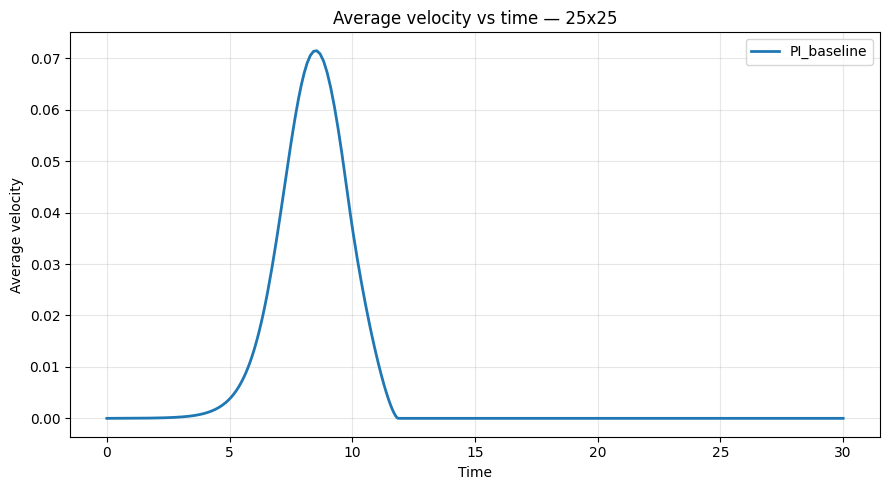

Saved: plots_velocity/velocity_vs_time_25x25.png


In [2]:
# ------------------------------------------------------------
# Plot: Average velocity vs time for each scenario (grid)
# ------------------------------------------------------------
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

def plot_velocity_vs_time(all_results, save_dir="plots", scales=None, use_physical_units=False):
    """
    Parameters
    ----------
    all_results : dict
        Output you built, mapping grid_label -> series dict.
        Each series entry must contain "times" and "mean_v".
    save_dir : str or Path
        Directory to save PNGs.
    scales : dict or None
        Optional per-grid scaling:
        {
          "1x1":   {"Tscale": <sec_per_env_unit>, "Vscale": <m_per_env_vel>},
          "25x25": {"Tscale": ..., "Vscale": ...},
          ...
        }
        If None, no scaling is applied.
    use_physical_units : bool
        If True, axis labels use (s) and (m/s).
    """
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    for grid_label, series in all_results.items():
        plt.figure(figsize=(9, 5))
        any_plotted = False

        for name, data in series.items():
            t = np.asarray(data.get("times", []), dtype=float)
            v = np.asarray(data.get("mean_v", []), dtype=float)
            if t.size == 0 or v.size == 0:
                continue

            # Optional scaling to physical units
            if scales and grid_label in scales:
                Tscale = float(scales[grid_label].get("Tscale", 1.0))
                Vscale = float(scales[grid_label].get("Vscale", 1.0))
            else:
                Tscale, Vscale = 1.0, 1.0

            t_plot = t * Tscale
            v_plot = v * Vscale

            plt.plot(t_plot, v_plot, lw=2, label=name)
            any_plotted = True

        if not any_plotted:
            plt.close()
            print(f"[plot_velocity_vs_time] No valid series to plot for '{grid_label}'.")
            continue

        plt.xlabel("Time (s)" if use_physical_units else "Time")
        plt.ylabel("Average velocity (m/s)" if use_physical_units else "Average velocity")
        plt.title(f"Average velocity vs time — {grid_label}")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()

        out = save_dir / f"velocity_vs_time_{grid_label}.png"
        plt.savefig(out, dpi=150, bbox_inches="tight")
        plt.show()
        print(f"Saved: {out}")

# --------------------------
# Example usage (after your loop populates `all_results`)
# --------------------------

# If you want raw env units:
plot_velocity_vs_time(all_results, save_dir="plots_velocity", scales=None, use_physical_units=False)

# If you stored/know physical scales per grid, pass them like this:
# scales = {
#   "1x1":   {"Tscale": fault_1x1.Tscale / fault_1x1.second, "Vscale": fault_1x1.Vscale},
#   "25x25": {"Tscale": fault_25.Tscale / fault_25.second,   "Vscale": fault_25.Vscale},
# }
# plot_velocity_vs_time(all_results, save_dir="plots_velocity_phys", scales=scales, use_physical_units=True)
